Notebook to develop calculations for barotropic to baroclinic conversion,

$ C = <p'(-H) \vec{U}\cdot\nabla H>$

where $p'$ is pressure perturbation, $\vec{U}$ is barotropic velocity, $H$ is bottom topography. So bottom depth is z = -H(x,y)

$ p' = \int_z^0 N^2\zeta dz' - \frac{1}{H} \int_{-H}^0 \int_z^0 N^2\zeta dz' dz$

and $\zeta$ is isopycncal displacement. $<>$ denote an average over a tidal period. See Carter et al (2008), Energetics of M2 Barotropic to Baroclinic Tidal Conversion at the Hawaiian Islands

Alternatively, Kelly et al 2010 Internal‐tide energy over topography, defines

$ p' = p(x,z) - P(x)$

where $p(x,z)$ is the total pressure and $P(x)$ is the depth-averaged pressure.

$P(x) = \frac{1}{H}\int_{-H}^0 p(x,z)dz $

This is bizarre to me because were it the time dependency? I guess, in the model, the depth levels are actually changing with time, so both $z$ and $dz$ are time dependent. 

I will use the Kelly et al 2010 apporach. Note, Kelly warns of using $C_S$ as a correction in shallow areas.

In [2]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt

from nowcast import analyze
from salishsea_tools import viz_tools, psu_tools

import gsw

%matplotlib inline

In [3]:
mesh_mask = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/mesh_mask_SalishSea2.nc')
grid = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')

bathy = grid.variables['Bathymetry'][:]

# 1. Calculate bathymetry gradient

In [4]:
def bathymetry_gradient(bathy, mesh):
    e1t = mesh.variables['e1t'][0,:,:]
    e2t = mesh.variables['e2t'][0,:,:]
    
    diff_x = bathy[:,1:] - bathy[:,:-1]
    diff_y = bathy[1:,:] - bathy[:-1.:]
    diff_x = np.concatenate([np.zeros((bathy.shape[0],1)), diff_x], axis=1) #pad with zeros in first row
    diff_y = np.concatenate([np.zeros((1, bathy.shape[1])), diff_y], axis=0) # pad with zeros in first column
    
    hx = diff_x/e1t
    hy = diff_y/e2t
    
    return hx, hy

In [5]:
hx, hy = bathymetry_gradient(bathy, mesh_mask)

/home/nsoontie/anaconda3/envs/analysis/lib/python3.5/site-packages/numpy/ma/core.py:3114: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dout = self.data[indx]
/home/nsoontie/anaconda3/envs/analysis/lib/python3.5/site-packages/numpy/ma/core.py:3169: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dout._mask = _mask[indx]


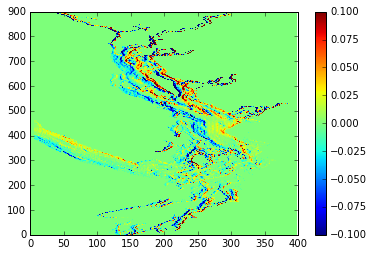

In [6]:
plt.pcolormesh(-hx,vmin=-.1,vmax=.1)
plt.colorbar()

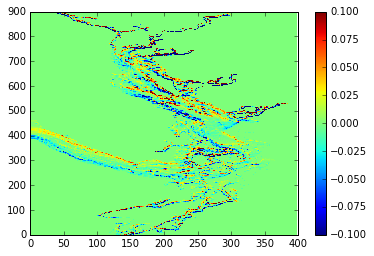

In [7]:
plt.pcolormesh(-hy,vmin=-.1,vmax=.1)
plt.colorbar()

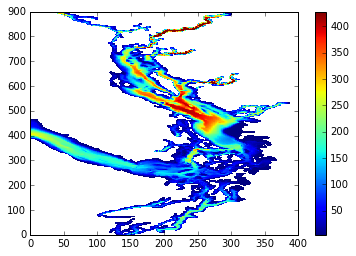

In [8]:
plt.pcolormesh(bathy)
plt.colorbar()

Check that barortopic w makes sense

In [9]:
fU = nc.Dataset('/results/SalishSea/nowcast/01apr15/SalishSea_1h_20150401_20150401_grid_U.nc')
fV = nc.Dataset('/results/SalishSea/nowcast/01apr15/SalishSea_1h_20150401_20150401_grid_V.nc')
fT = nc.Dataset('/results/SalishSea/nowcast/01apr15/SalishSea_1h_20150401_20150401_grid_T.nc')
u = fU.variables['vozocrtx'][:]
v = fV.variables['vomecrty'][:]
ssh = fT.variables['sossheig']
umask = mesh_mask.variables['umask'][:] + np.zeros(u.shape)
vmask = mesh_mask.variables['vmask'][:] + np.zeros(v.shape)
tmask = mesh_mask.variables['tmask'][:]
e3t_0 = mesh_mask.variables['e3t'][:]
e3u_0 = mesh_mask.variables['e3u'][:]
e3v_0 = mesh_mask.variables['e3v'][:]
gdept_0 = mesh_mask.variables['gdept'][:]
gdepw_0 = mesh_mask.variables['gdepw'][:]

u_depav = analyze.depth_average_mask(u,e3u_0[0,:,:,:], umask[0,:,:,:], depth_axis=1)
v_depav = analyze.depth_average_mask(v,e3v_0[0,:,:,:], vmask[0,:,:,:], depth_axis=1)

udepav_m = np.ma.masked_array(u_depav, mask = 1-umask[:,0,:,:])
vdepav_m = np.ma.masked_array(v_depav, mask = 1-vmask[:,0,:,:])
udepav_s,vdepav_s = viz_tools.unstagger(udepav_m,vdepav_m)

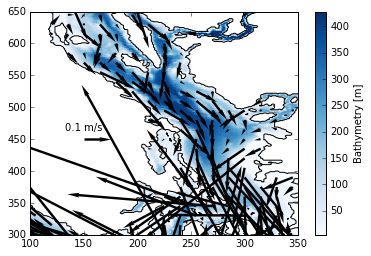

In [10]:
st=15
t=15
xx, yy = np.meshgrid(np.arange(v_depav.shape[-1]), np.arange(v_depav.shape[-2]))
fig,ax=plt.subplots(1,1)
mesh=ax.pcolormesh(bathy,cmap='Blues')
cbar=plt.colorbar(mesh,ax=ax)
cbar.set_label('Bathymetry [m]')
q=ax.quiver(xx[::st,::st],yy[::st,::st],udepav_s[t,::st,::st],vdepav_s[t,::st,::st],scale=1,
            color='k',width=0.009,headwidth=2,)
ax.quiverkey(q,150,450,.1,'0.1 m/s', color='k',coordinates='data')
ax.set_xlim([100,350])
ax.set_ylim([300,650])
viz_tools.plot_coastline(ax,grid)

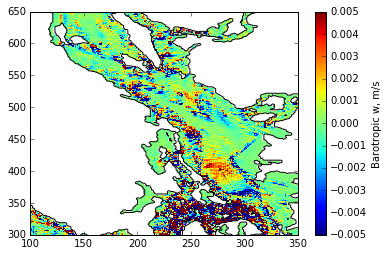

In [11]:
wB = -udepav_s*hx[1:,1:] + -vdepav_s*hy[1:,1:]
fig,ax=plt.subplots(1,1)
mesh=ax.pcolormesh(wB[t,:,:],vmin=-.005,vmax=.005)
cbar = plt.colorbar(mesh,ax=ax)
cbar.set_label('Barotropic w, m/s')
ax.set_xlim([100,350])
ax.set_ylim([300,650])
viz_tools.plot_coastline(ax,grid)
del u, v, udepav_s, vdepav_s, udepav_m, vdepav_m, u_depav, v_depav, e3u_0, e3v_0, umask, vmask

* Between Gulf islands and Tsawwassen, depth averatged currents are mostly towards the south east (ignoring bounday pass). Topoography is getting shallower so we should have upward w, which we do.
* The barotropic vertical velocity is really noisy, especially in Boundary Pass where currents are large and bathymetry is complex and steep.  This is probably mostly because the bathymetry gradients are noisy. 


# Calculating baroclinic pressure
Things needed:
* time-dependent depth levels and vertical scale factors
* density from T,S, depth (converted to pressure...?)
* pressure derived from hydrostatic relation
* depth averaging - not sure if analyze function will work because of time dependent scale factors

In [36]:
sal = fT.variables['vosaline'][:]
temp = fT.variables['votemper'][:]
rho = psu_tools.calculate_density(temp, sal)

In [37]:
def calculate_pressure(rho, e3t_t, tmask):
    """Integrate density to calulate pressure.
    Use time-dependent scale factors"""
    g = 9.81 # is there a constant module that I an grab this from?
    
    p = np.cumsum(rho*e3t_t*tmask, axis=1)*tmask

    return p
    

In [38]:
 p =calculate_pressure(rho, e3t_t, tmask)

In [39]:
p[0,:,400,300]

array([  1036.08051487,   2074.07591496,   3117.84221575,   4164.48294613,
         5211.9199812 ,   6259.15283141,   7305.69015154,   8351.34096678,
         9396.20508548,  10440.62558553,  11485.33624868,  12531.81451207,
        13582.99198586,  14644.6345185 ,  15727.958694  ,  16854.67667365,
        18066.62488541,  19444.03613877,  21138.47679449,  23428.31328082,
        24200.8218939 ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,      0.        ,      0.        ])

In [40]:
ssh[0,400,300]

0.39984733

In [41]:
(gdept_t*tmask)[0,:,400,300]

array([  0.51631032,   1.54823368,   2.57876437,   3.60790793,
         4.63567509,   5.66208675,   6.68718356,   7.71104458,
         8.73382359,   9.75581967,  10.77761448,  11.80033913,
        12.82619266,  13.85944853,  14.90840452,  15.98914619,
        17.13275746,  18.39893766,  19.9009913 ,  21.84911162,
        23.34643151,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ])

In [12]:
p_gsw = gsw.p_from_z(-gdept_0, fT.variables['nav_lat'][:])

In [15]:
p_gsw[0,:,400,300]

array([   0.50427814,    1.51284036,    2.52141311,    3.53000162,
          4.53861623,    5.54727618,    6.55602138,    7.5649259 ,
          8.57413787,    9.58394394,   10.59490056,   11.60809468,
         12.62563961,   13.65165232,   14.69413597,   15.76863425,
         16.9052497 ,   18.16197734,   19.6493781 ,   21.57408782,
         23.15158546,   23.91276083,   34.98544511,   44.9034412 ,
         58.99307923,   77.25521393,   98.92556944,  122.94567159,
        148.40112176,  174.66932963,  201.378541  ,  228.32210898,
        255.38942852,  282.52246347,  309.69112086,  336.87982774,
        364.08054163,  391.28919378,  418.50362547,  445.7227564 ])

In [ ]:
gsw.p_from_z()